In [1]:
! pip install --quiet gensim

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac = 0.5).reset_index(drop = True)

In [2]:
import re 

In [3]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    txt_pat =  r"(?u)\b\w\w+\b"
    txt_pat = re.compile(txt_pat)
    return(txt_pat.findall(s))

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    pass

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer = CountVectorizer(tokenizer=tokenize, preprocessor=clean_yelp)

# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
tf_matrix = vectorizer.fit_transform(yelps.text)

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD
t_svd = TruncatedSVD(n_components = 100)
pca = t_svd.fit_transform(tf_matrix)

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

/home/hector/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [6]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

cutoffs = [50,100,250,500,1000,5000,10000,25000,40000]


tf_results  = [test_holdout_vectors(tf_matrix, yelps.positive, cut) for cut in cutoffs]

pca_results = [test_holdout_vectors(pca, yelps.positive, cut) for cut in cutoffs]

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

In [7]:
from matplotlib import pyplot as plt

plt.plot(cutoffs, tf_results)
plt.plot(cutoffs, pca_results)
plt.legend(['TF matrix', 'SVD'])
plt.xscale("log")
plt.title("Accuracy Comparisson")
plt.xlabel("Level of Cutoff")
plt.ylabel("Accuracy")

Text(0,0.5,'Accuracy')

### Do the word embeddings generated via SVD allow you to pull information from the  unlabeled data and improve your score given a small training set?

Given a small training set it seems that both are very simillar, but while the level of cutoff increases the accuracy of SVD decreases. 

In [8]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model = Word2Vec(sentences, window = 5, min_count = 4, workers = 5)

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

/home/hector/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [ ]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [9]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) 
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [10]:
w2v_matrix = np.array([embed_w2v(t, model) for t in sentences])

w2v_results = [test_holdout_vectors(w2v_matrix, yelps.positive, cut) for cut in cutoffs]

Text(0,0.5,'Accuracy')

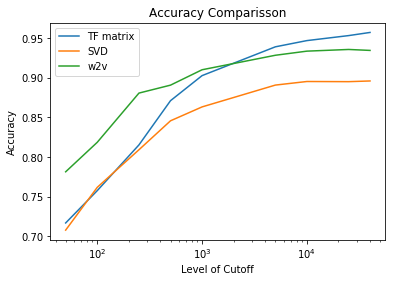

In [11]:
plt.plot(cutoffs, tf_results)
plt.plot(cutoffs, pca_results)
plt.plot(cutoffs, w2v_results)
plt.legend(['TF matrix', 'SVD', 'w2v'])
plt.xscale("log")
plt.title("Accuracy Comparisson")
plt.xlabel("Level of Cutoff")
plt.ylabel("Accuracy")

### is word2vec better? At what training-set sizes does it help more? 

In [12]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [13]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [14]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

vectorizer_twitter = CountVectorizer(preprocessor = clean_twitter, tokenizer = tokenize)
tf_mat_twit = vectorizer_twitter.fit_transform(tweets)

t_svd_twit = TruncatedSVD(n_components = 100)
pca_twit = t_svd.fit_transform(tf_mat_twit)

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)

sentences_twit = [tokenize(clean_twitter(t)) for t in tweets]
model_twit = Word2Vec(sentences_twit, window = 5, min_count = 4, workers = 5)


# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

In [15]:
# embed twitter data

w2v_tweets  = np.array([embed_w2v(t, model_twit) for t in sentences_twit])

In [17]:
display(model_twit.wv.most_similar (positive="trump"))
display(model_twit.wv.most_similar (positive="hillary"))
display(model_twit.wv.most_similar(positive=["democrat", "hillary"], negative=["trump"]))

[('trumps', 0.6537060737609863),
 ('him', 0.5728135704994202),
 ('hillary', 0.5695774555206299),
 ('obama', 0.565464973449707),
 ('he', 0.5652813911437988),
 ('gop', 0.5499082803726196),
 ('bernie', 0.5365509390830994),
 ('campaign', 0.5256706476211548),
 ('rubio', 0.5195817947387695),
 ('the', 0.5168758630752563)]

[('hrc', 0.7132449746131897),
 ('hilary', 0.6834307909011841),
 ('sanders', 0.661361575126648),
 ('she', 0.639671802520752),
 ('foundation', 0.6064809560775757),
 ('crookedhillary', 0.6018665432929993),
 ('killary', 0.5843306183815002),
 ('hillaryclinton', 0.5793141722679138),
 ('pardongate', 0.5790168046951294),
 ('her', 0.5784761905670166)]

[('dem', 0.6293402910232544),
 ('democratic', 0.6274920701980591),
 ('hilary', 0.5546096563339233),
 ('hillaryclinton', 0.5131926536560059),
 ('killary', 0.49581629037857056),
 ('dnc', 0.4827871322631836),
 ('socialist', 0.48038214445114136),
 ('republican', 0.4764871299266815),
 ('hrc', 0.47107356786727905),
 ('progressive', 0.4621732234954834)]

In [ ]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [22]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

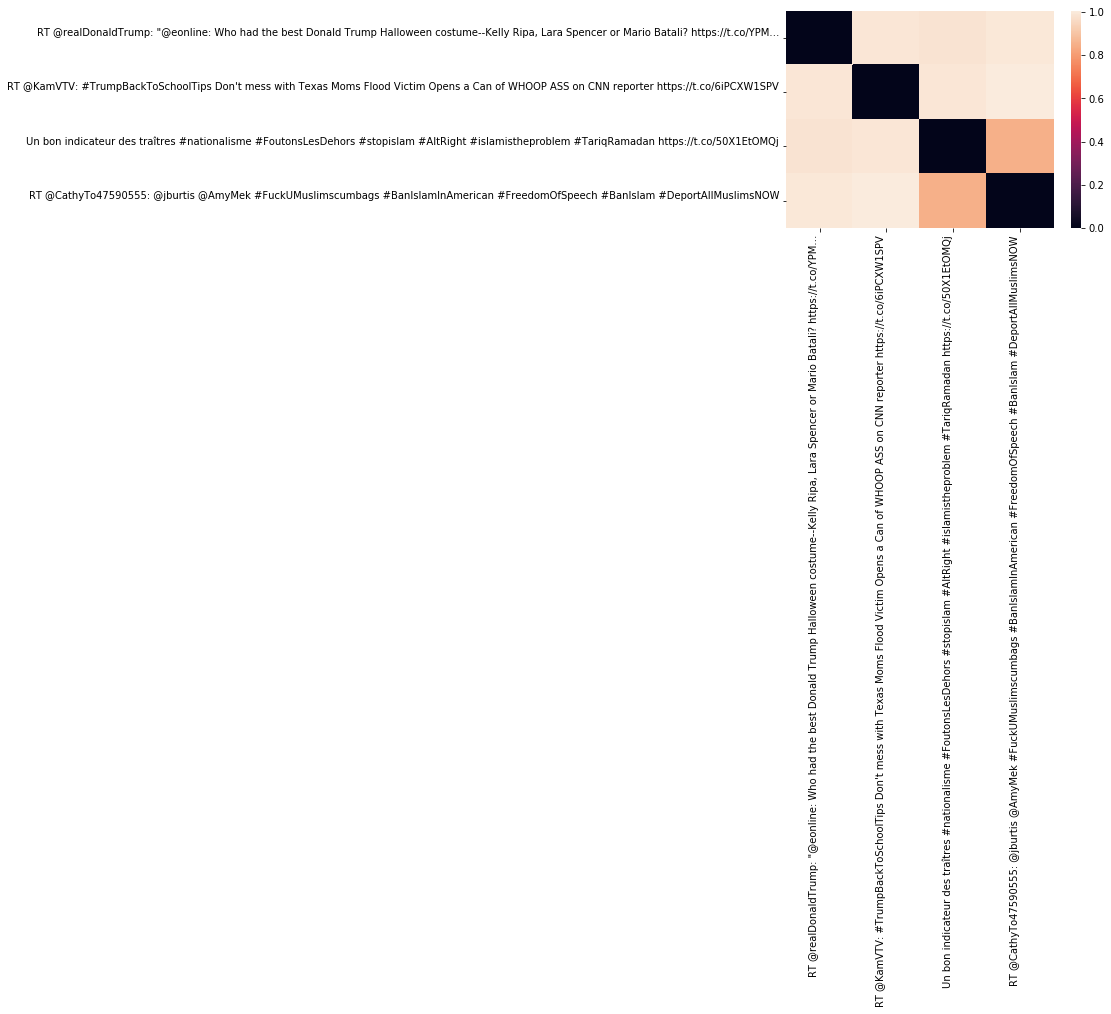

In [23]:
idx = np.random.randint(0, high=len(tweets), size=4)
visualize_dist(pca_twit, tweets, idx)

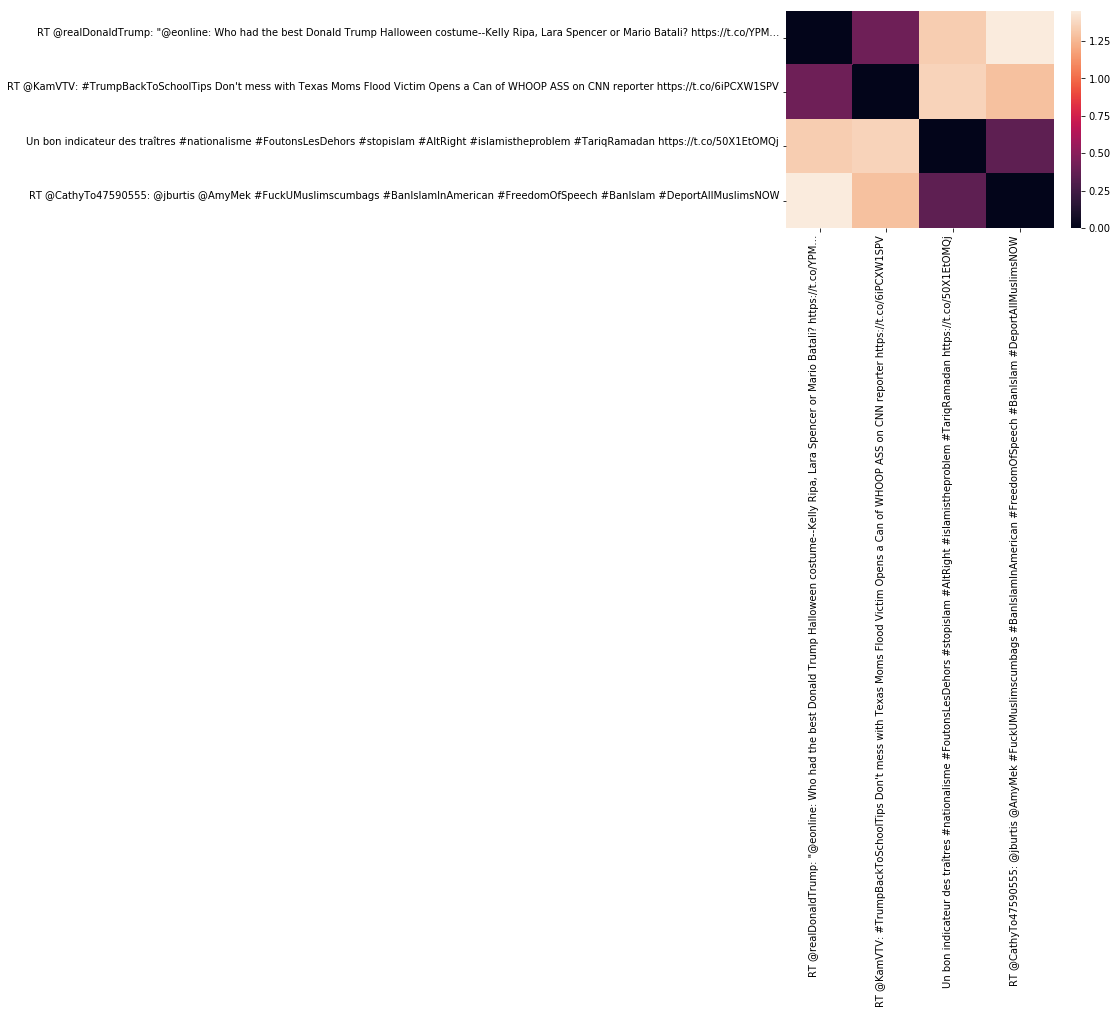

In [24]:
visualize_dist(w2v_tweets, tweets, idx)

### Does one embedding seem better than another?

The W2V looks better than the SVD.

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data